In [86]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
%matplotlib inline 
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn import linear_model,svm,ensemble,tree

# special matplotlib argument for improved plots
from matplotlib import rcParams

import samples
reload(samples)
import spectral
reload(spectral)
import audiolearning
reload(audiolearning)
import mytimer as mt
reload(mt)
print

In [2]:
FFT_BINS = 60;
FWIN = 25;
TWIN = 1;
NPERSEG = 1024;
TSUB = 1; #NOTE: this will be used only for training. Will experiment with test format later.
NSUB = 10;
#Last day of 'training' data
MONTH = 5;
DAY = 26;

In [3]:
train_samples,test_samples = samples.getGeneralizationTestSet(MONTH,DAY,Tsub=TSUB,Nsub=NSUB,READ_IN=True)

Imported 1050 Supersamples


In [8]:
class phi_sped_mfcc:
    LEN = 0;
    def __init__(self,fft_bins):
        #self.LEN = fft_bins;
        self.LEN = fft_bins+13;
        self.fft_bins = fft_bins;

    def get_phi(self,sample):
        '''
        Takes in a super_sample and returns a feature array. Breaks the super_sample
        down into samples. Each row of the returned value corresponds to a sample
        in the super sample.
        '''

        XSPED = spectral.getSupersampleSPED(sample,self.fft_bins,fwin=FWIN,twin = TWIN,nperseg = NPERSEG,spacing="log")
        XMFCC = spectral.getSampleMFCC(sample)
        return np.hstack((XMFCC,XSPED))

In [11]:
data_file = 'generalization%02i%02i_%i_%i_%i_%i_%i_%i.pkl'%(MONTH,DAY,TSUB,NSUB,FFT_BINS,FWIN,TWIN,NPERSEG)
myPhi = phi_sped_mfcc(FFT_BINS)
extractor = audiolearning.Classifier(myPhi)

In [20]:
if os.path.exists(data_file):
    with open(data_file,"rb") as myPkl:
        (trainData,generalData) = pickle.load(myPkl);
        X_train = trainData.X_flat;
        Y_train = trainData.Y_flat;
        X_train_compact = trainData.X
        Y_train_compact = trainData.Y
        
        X_test = generalData.X_flat;
        Y_test = generalData.Y_flat;
        X_test_compact = generalData.X
        Y_test_compact = generalData.Y
    m, nsub, nfeat = np.shape(X_train_compact)
else:
    train_samples,test_samples = samples.getGeneralizationTestSet(MONTH,DAY,Tsub=TSUB,Nsub=NSUB,READ_IN=True)
    
    
    (X_test_compact,Y_test_compact) = extractor.extract_features(train_samples)
    m, nsub, nfeat = np.shape(X_test_compact)
    X_test = np.reshape(X_test_compact,(m*nsub,nfeat))
    Y_test = np.repeat(Y_test_compact,nsub)    
    generalData = samples.DataPhi()
    generalData.X = X_test_compact
    generalData.Y = Y_test_compact
    generalData.X_flat = X_test
    generalData.Y_flat = Y_test
    
    (X_train_compact,Y_train_compact) = extractor.extract_features(train_samples)
    m, nsub, nfeat = np.shape(X_train_compact)
    X_train = np.reshape(X_train_compact,(m*nsub,nfeat))
    Y_train = np.repeat(Y_train_compact,nsub)    
    trainData = samples.DataPhi()
    trainData.X = X_train_compact
    trainData.Y = Y_train_compact
    trainData.X_flat = X_train
    trainData.Y_flat = Y_train
    with open(data_file,'wb') as f:
        pickle.dump((trainData,generalData),f)

In [22]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

Number of Principal Components to explain 95.00% of variance: 50


PCA(copy=True, n_components=50, whiten=False)

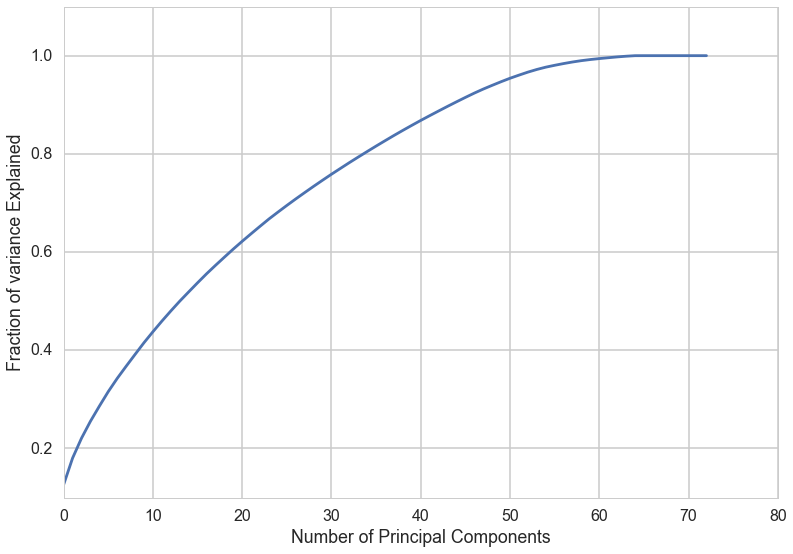

In [26]:
pca = PCA(n_components=None,whiten=False)

X_pca = pca.fit_transform(preprocessing.scale(X_train),Y_train)
var_thresh = 0.95
var_exp = pca.explained_variance_ratio_.cumsum()
plt.plot(var_exp)
num_pcs = np.where(var_exp>=var_thresh)[0][0]
plt.xlabel('Number of Principal Components')
plt.ylabel('Fraction of variance Explained')
print "Number of Principal Components to explain %.2f%% of variance: %d" %(var_thresh*100,num_pcs)
pca.set_params(n_components=num_pcs)

In [89]:
def plotRegions(regions,dataframe,i=None,j=None,ax=None):
    num = len(regions)
    colors = sns.color_palette("hls", 8)
    markers = ['^','o','x','v','<','>','*']
    if ax is None:
        fig =plt.figure()
        ax = Axes3D(fig,elev=-140, azim=80)
    if i==None:
        for region_name,color,marker in zip(regions,colors,markers):
            region = samples.Regions_dict[region_name]
            mask = dataframe['REGION']==region
            ax.scatter(dataframe[mask]['pc1'],dataframe[mask]['pc2'],dataframe[mask]['pc3'],c=color,label=region_name,marker=marker)
    else:
        region_name = samples.REGIONS[i]
        mask = dataframe['REGION']==i
        ax.scatter(dataframe[mask]['pc1'],dataframe[mask]['pc2'],dataframe[mask]['pc3'],c=colors[i],label=region_name,marker=markers[i])
        region_name = samples.REGIONS[j]
        mask = dataframe['REGION']==j
        ax.scatter(dataframe[mask]['pc1'],dataframe[mask]['pc2'],dataframe[mask]['pc3'],c=colors[j],label=region_name,marker=markers[j])


    plt.legend()
    return ax

# Plots suggest that PCA is making the data too scrunched together

<function matplotlib.pyplot.show>

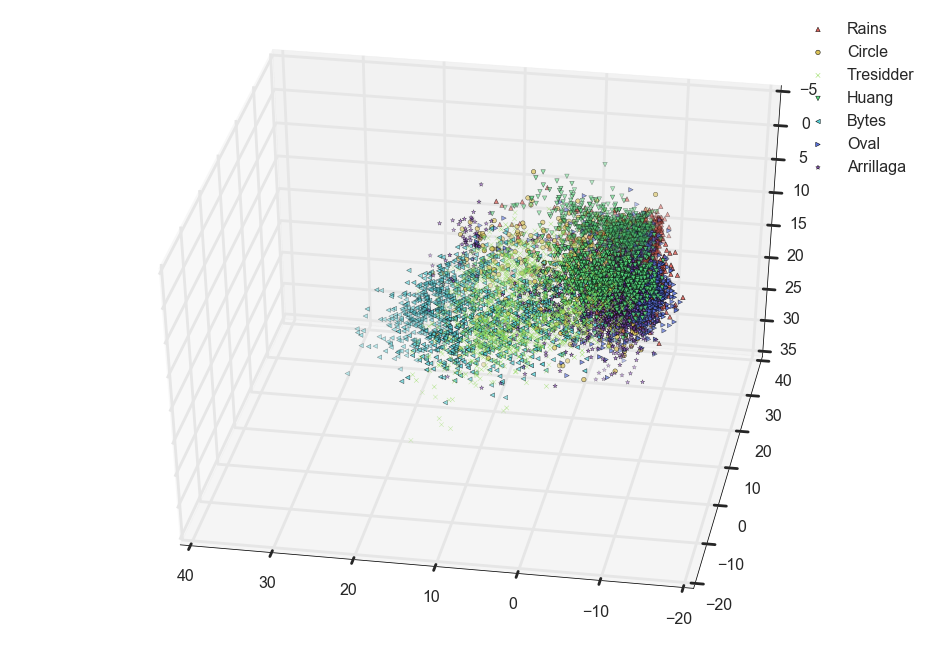

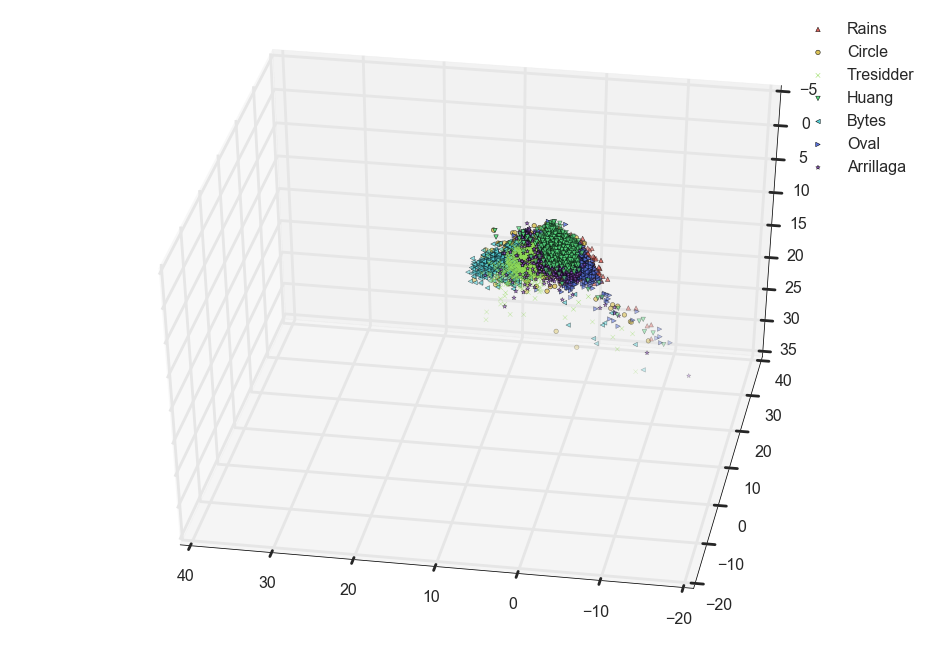

In [94]:
pca_df_test = pd.DataFrame()
test_pca = pca.transform(X_test)
for i in range(num_pcs):
    pca_df_test["pc%i" % (i+1)] = test_pca[:,i]
pca_df_test['REGION'] = Y_test
ax = plotRegions(samples.REGIONS,pca_df_test,ax=None)
xlims = ax.get_xlim()
ylims = ax.get_ylim()
zlims = ax.get_zlim()

pca_df_train = pd.DataFrame()
for i in range(num_pcs):
    pca_df_train["pc%i" % (i+1)] = X_pca[:,i]    
pca_df_train['REGION'] = Y_train
ax = plotRegions(samples.REGIONS,pca_df,ax=None)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_zlim(zlims)
plt.show

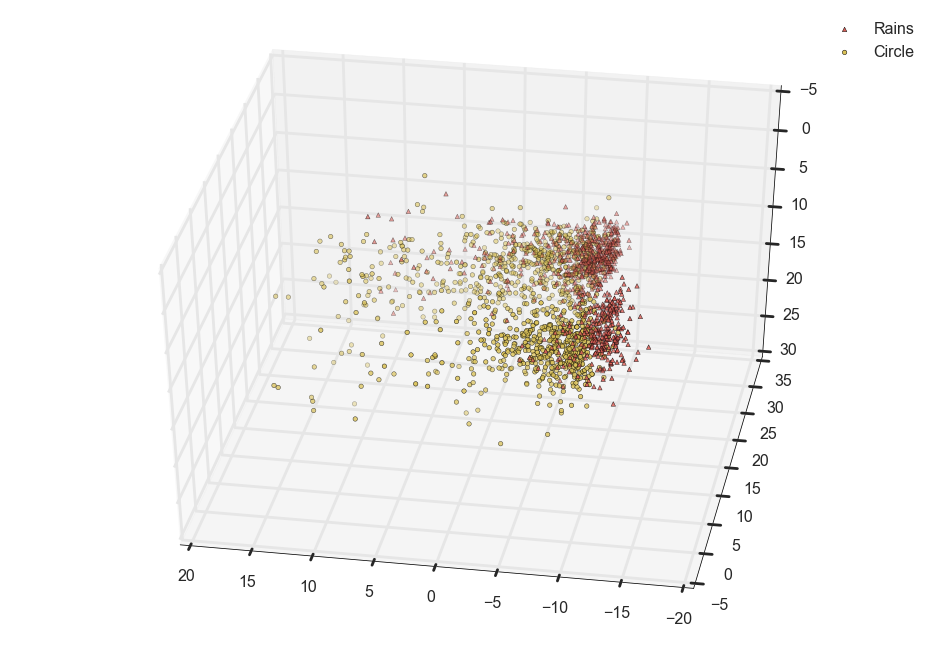

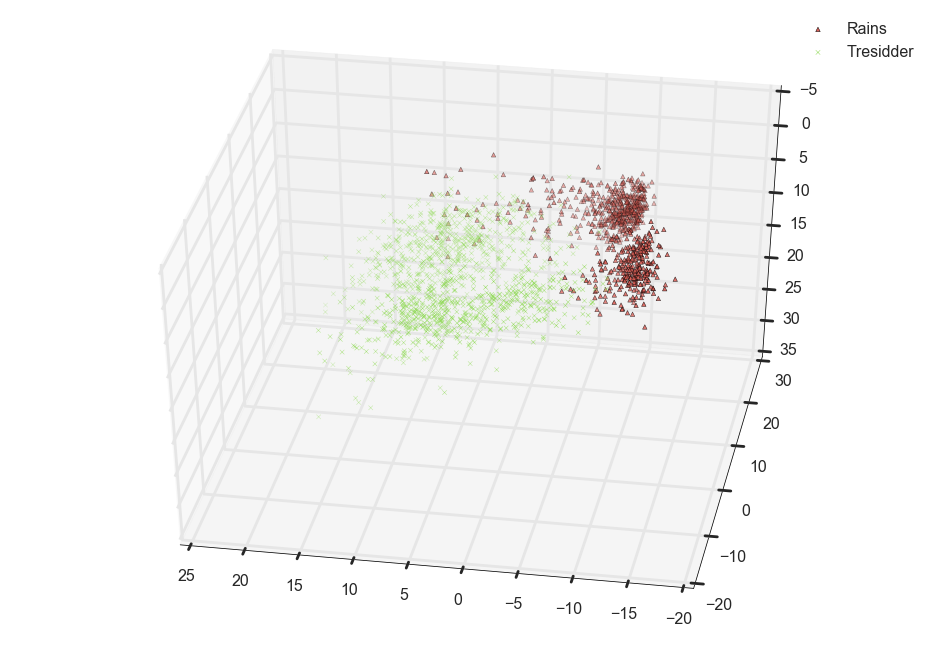

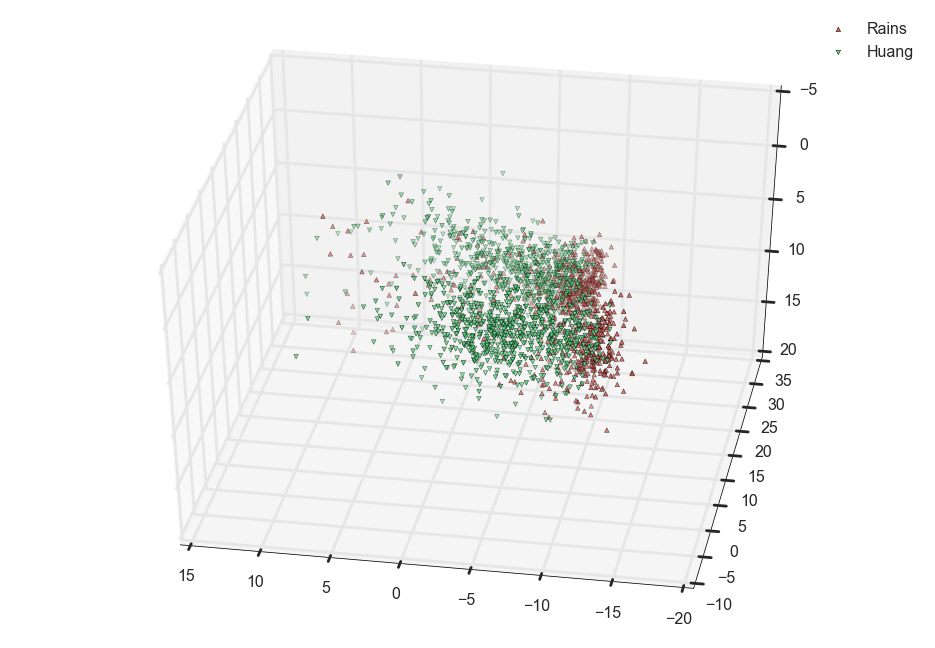

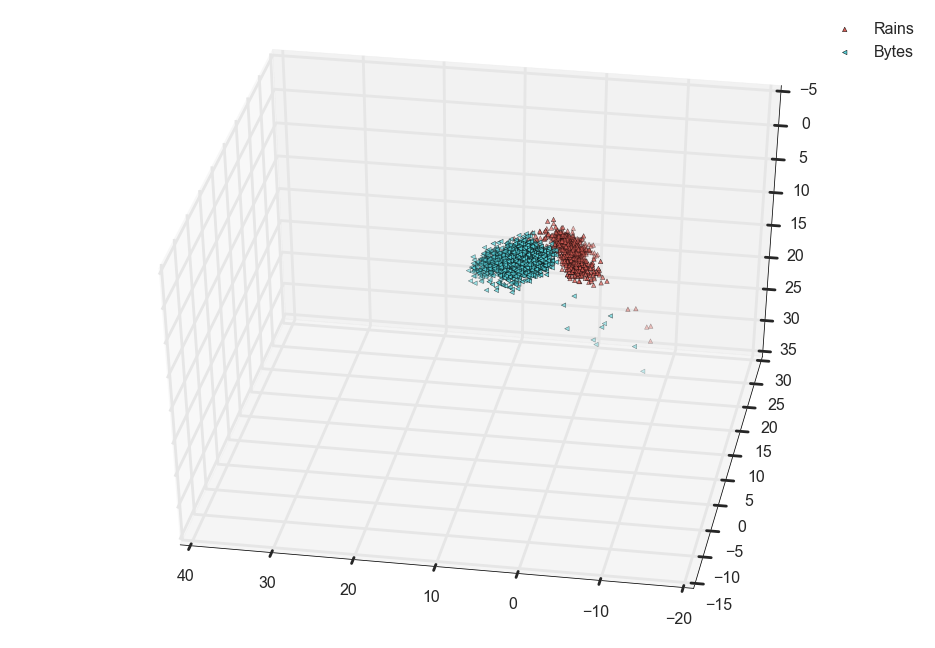

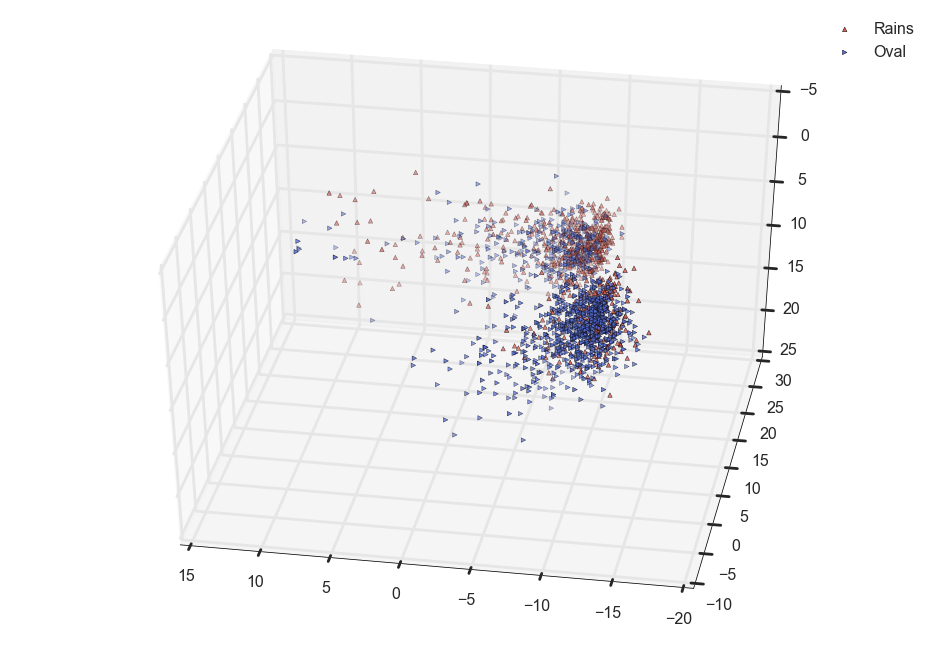

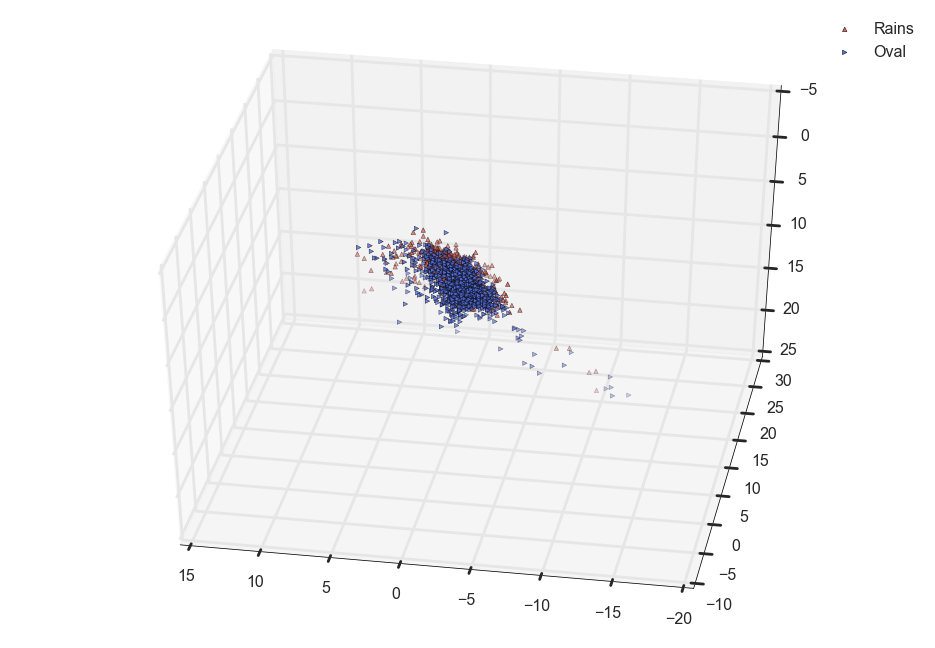

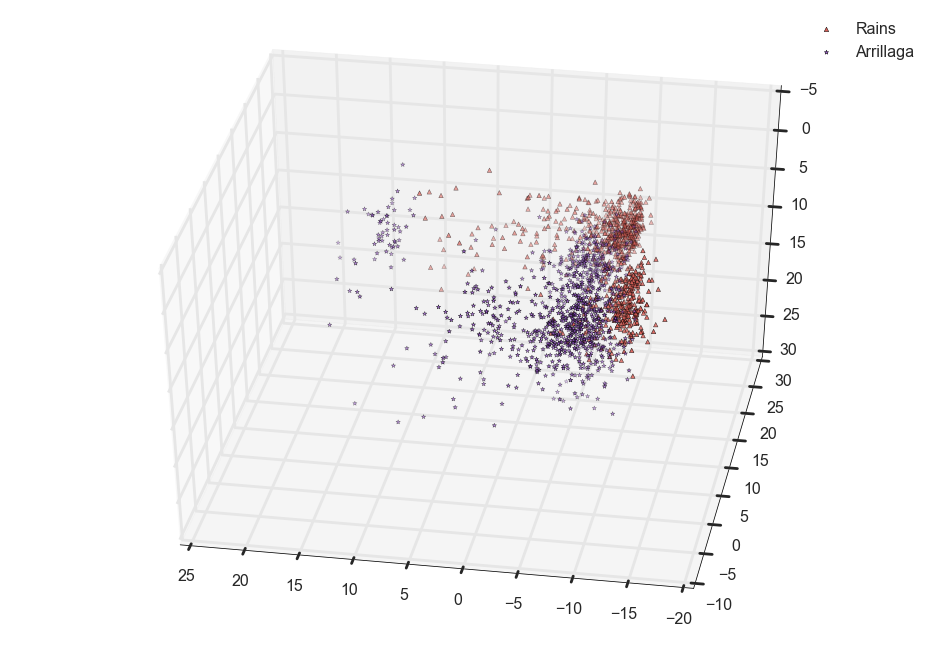

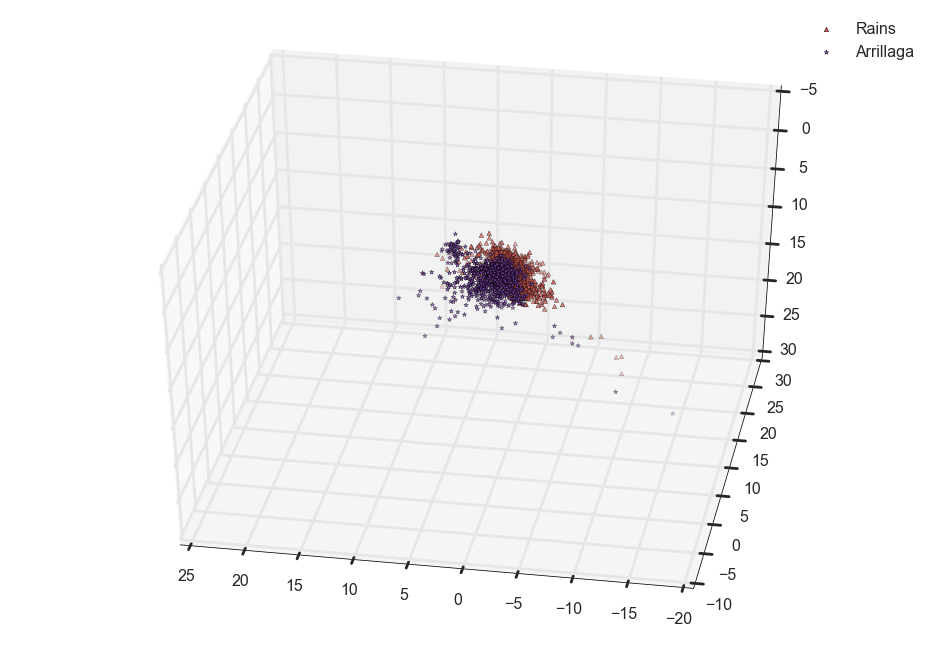

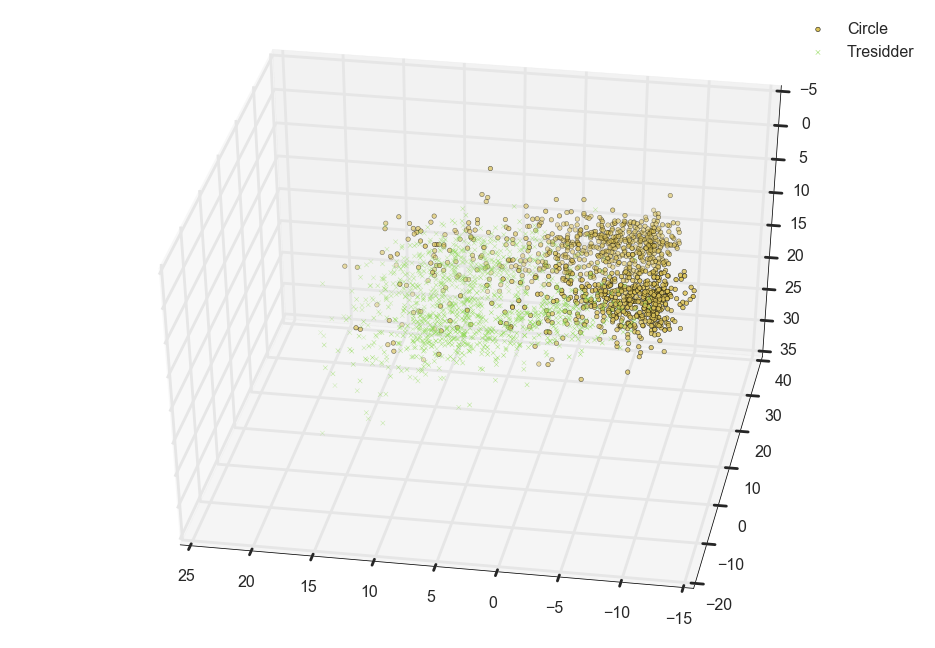

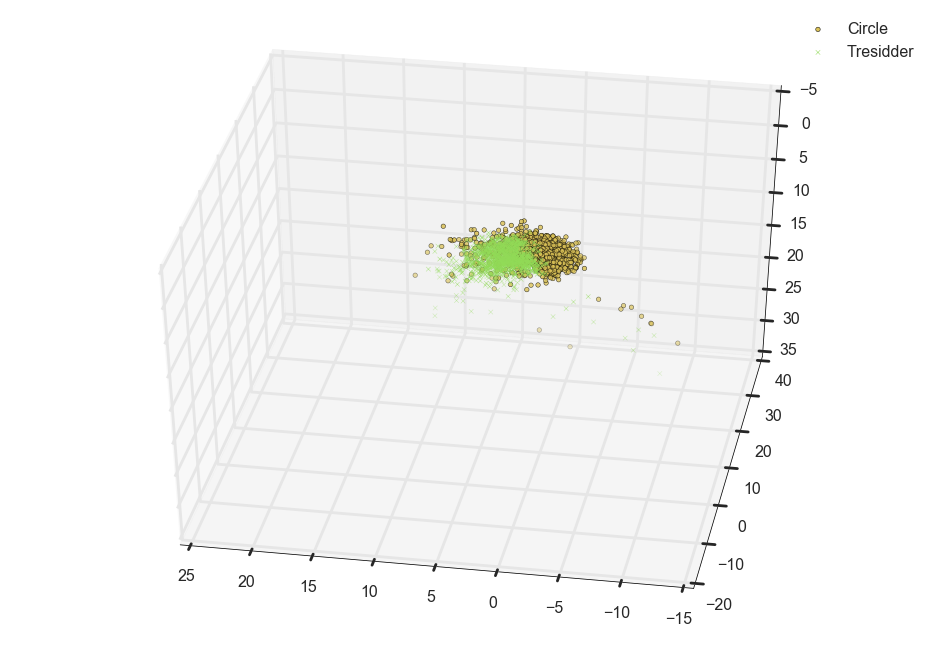

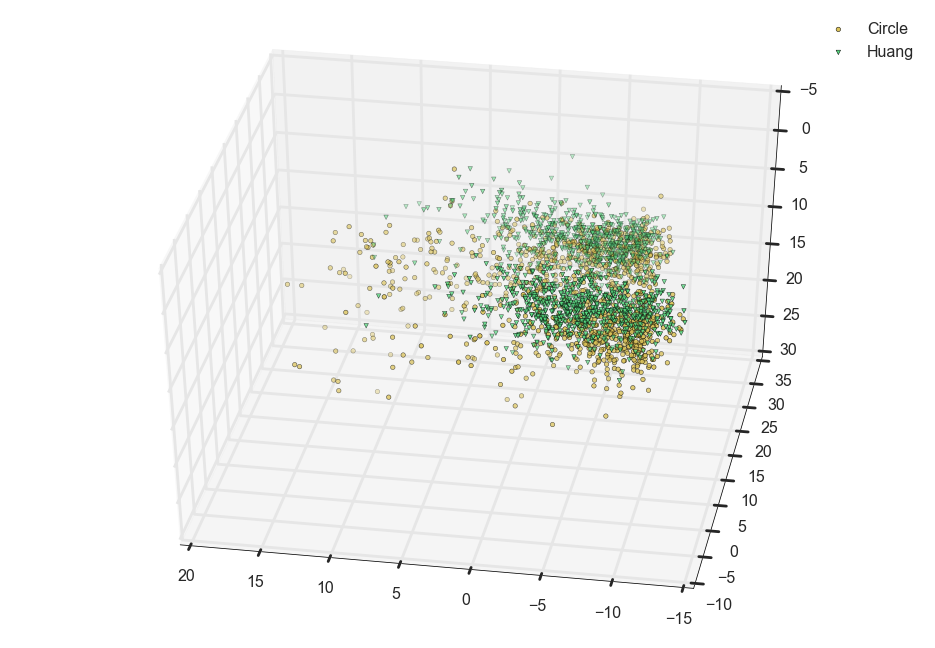

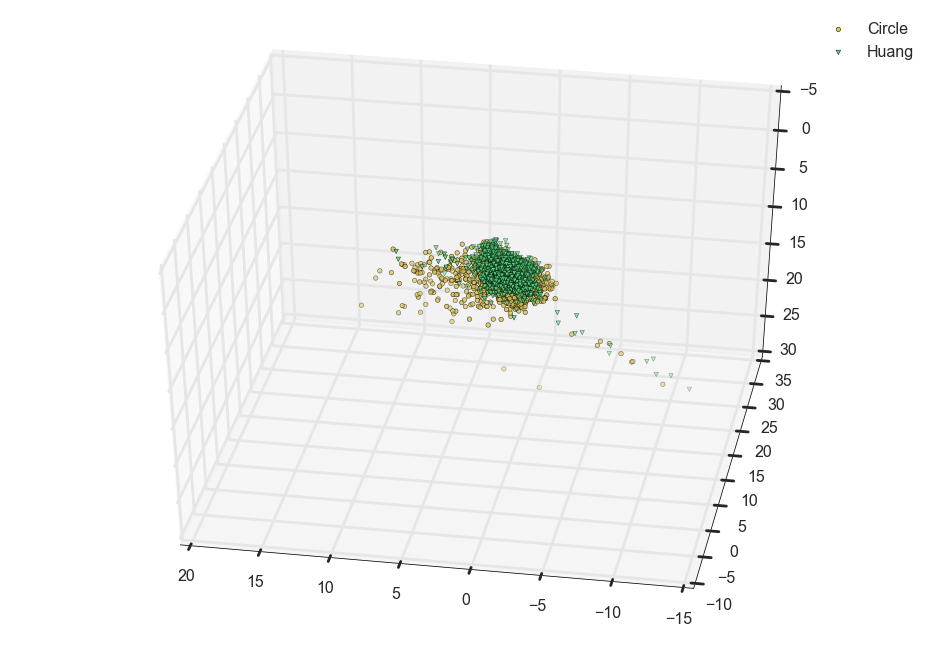

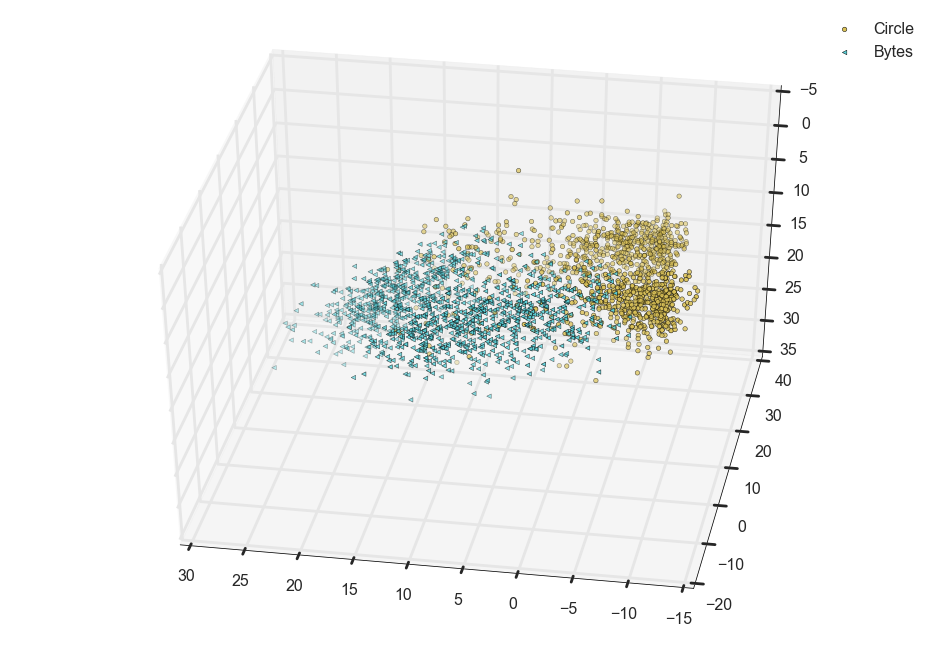

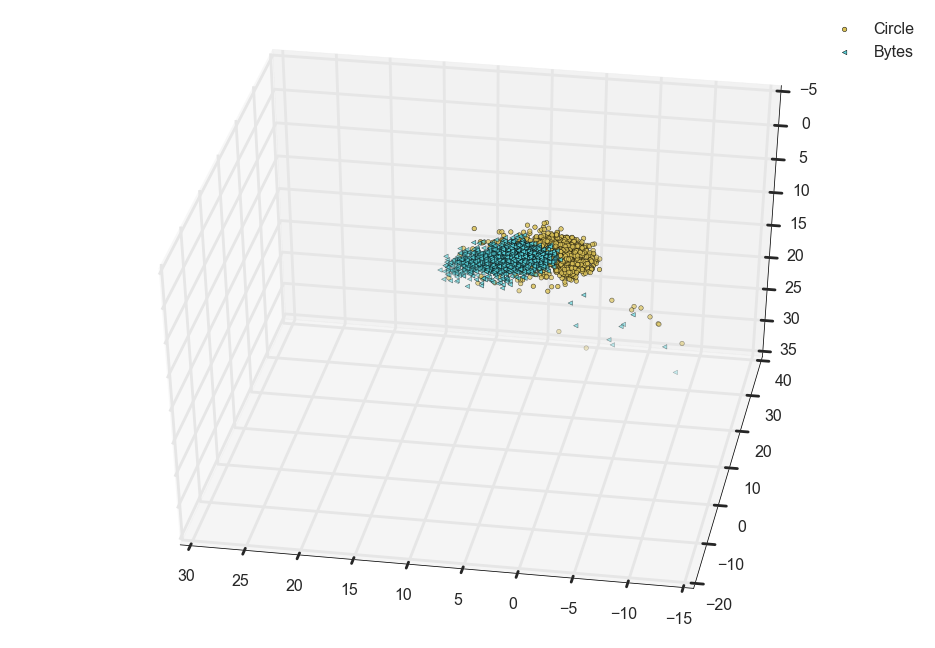

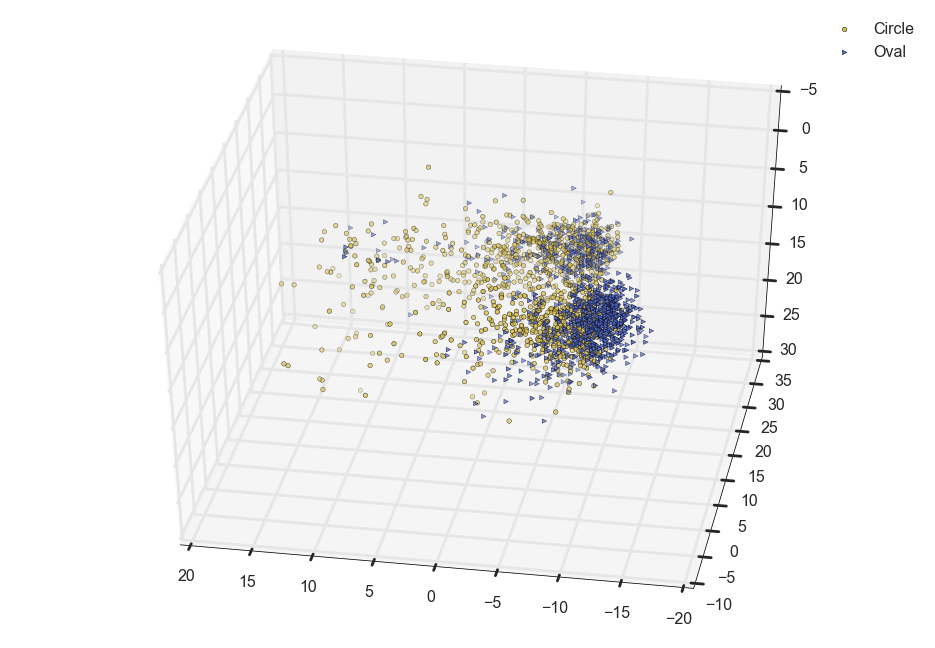

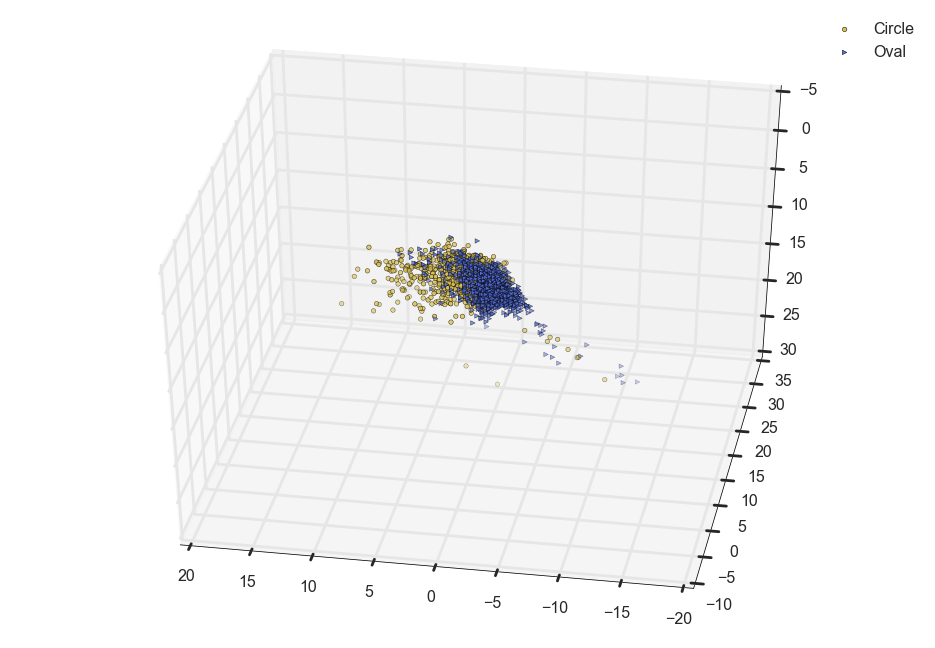

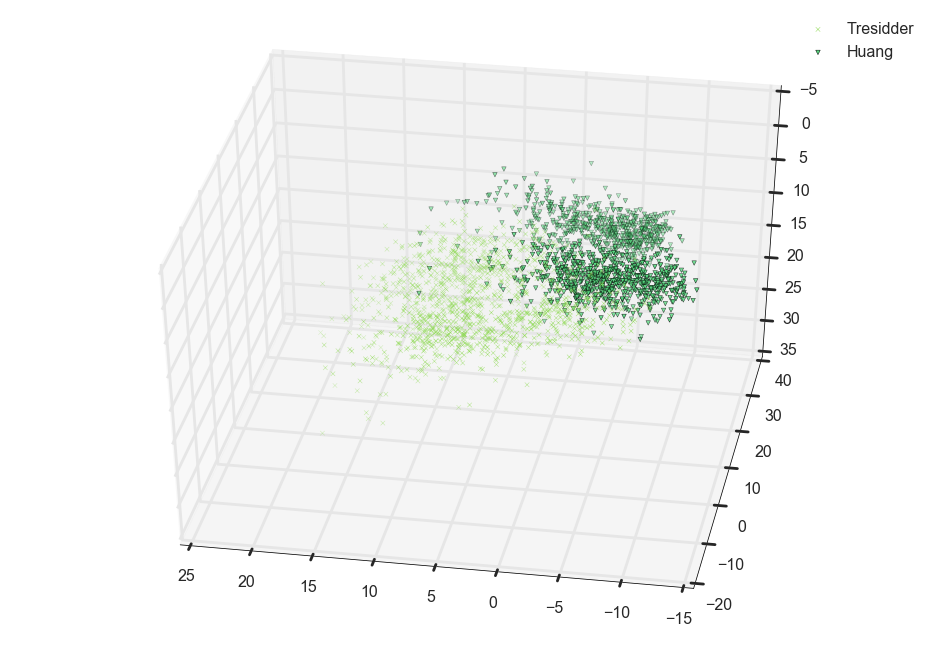

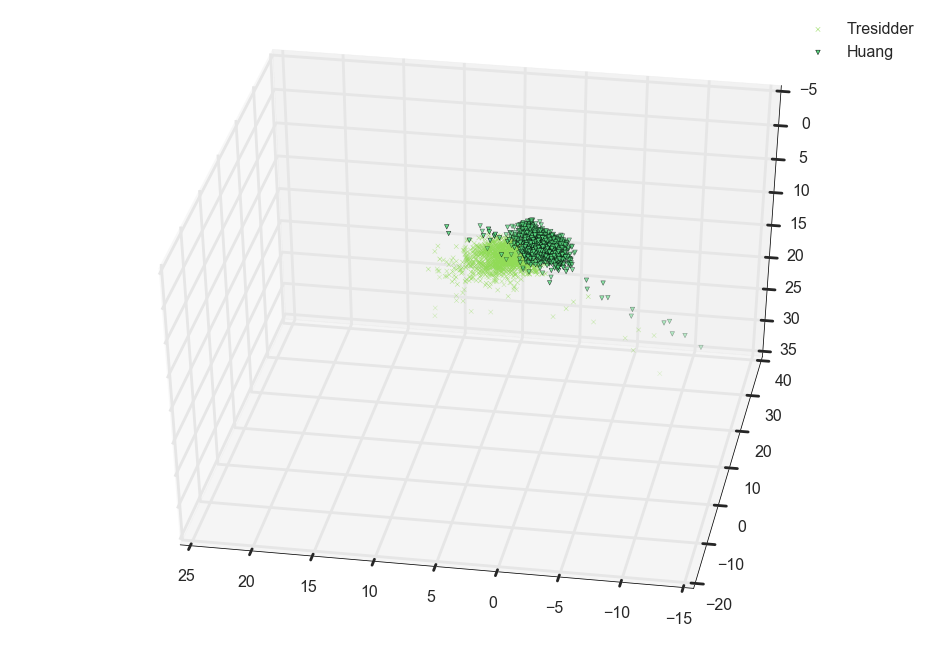

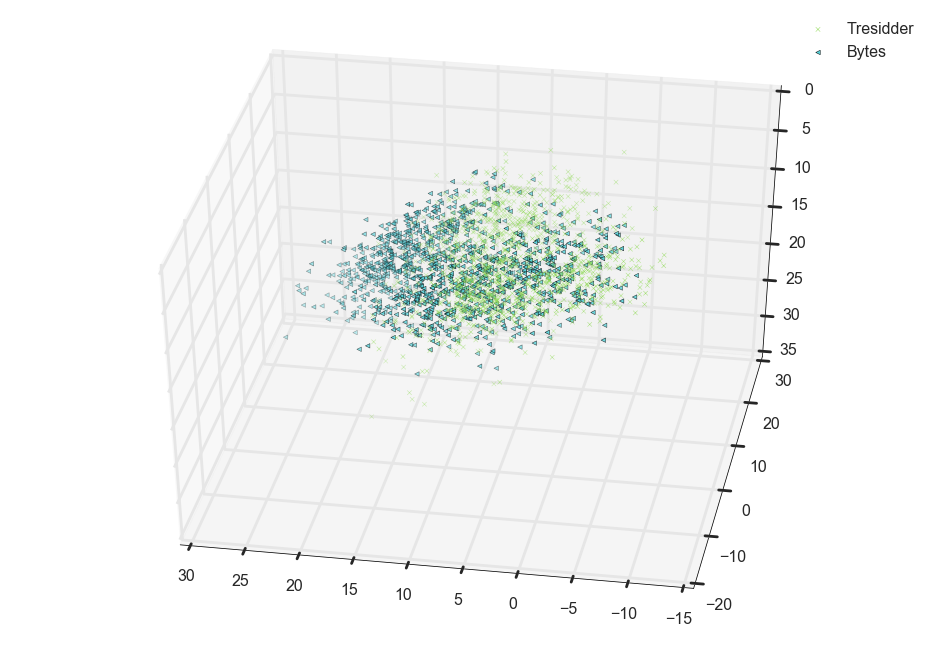

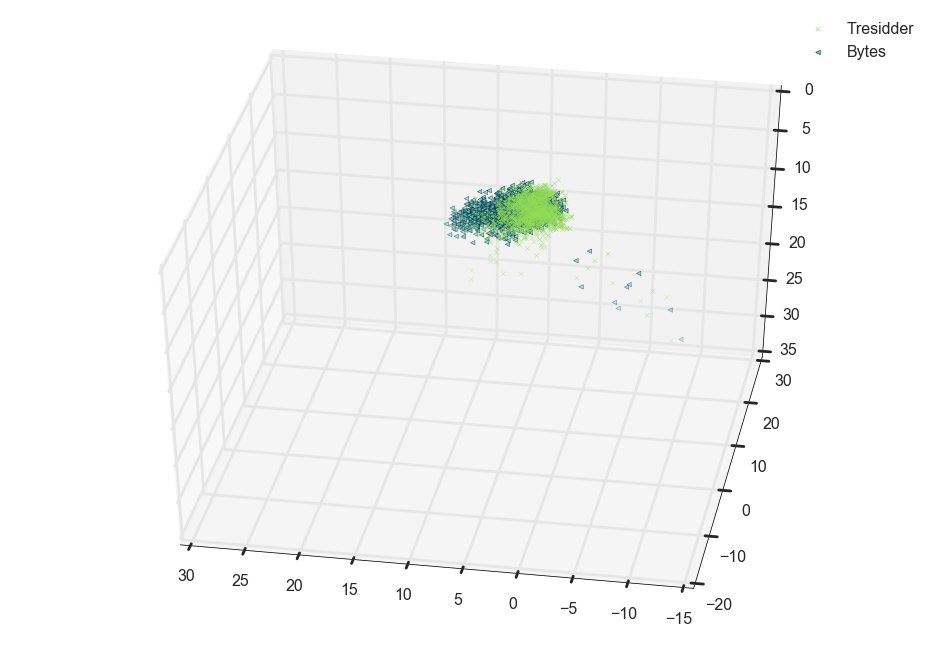

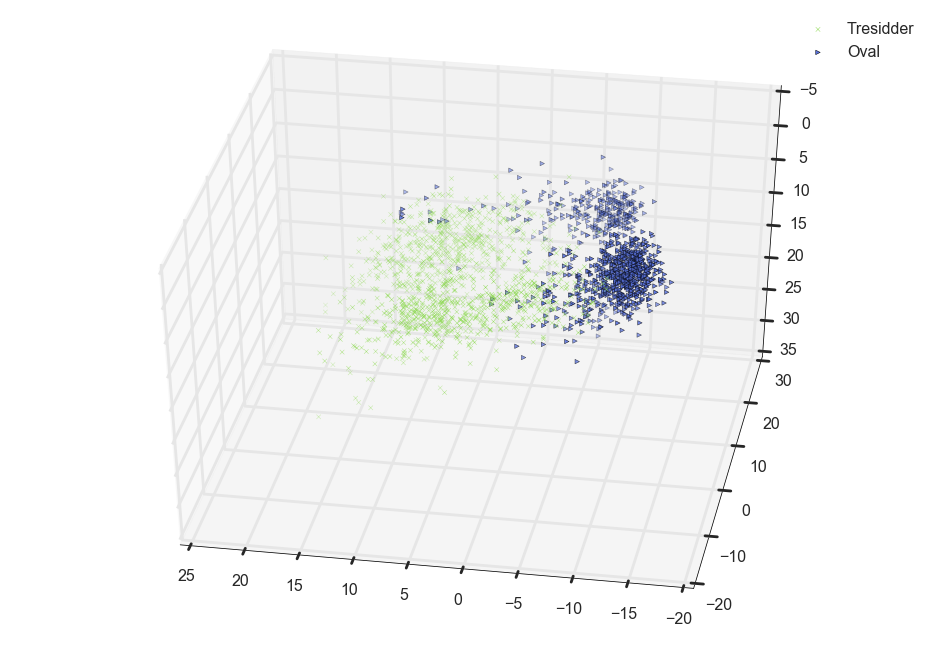

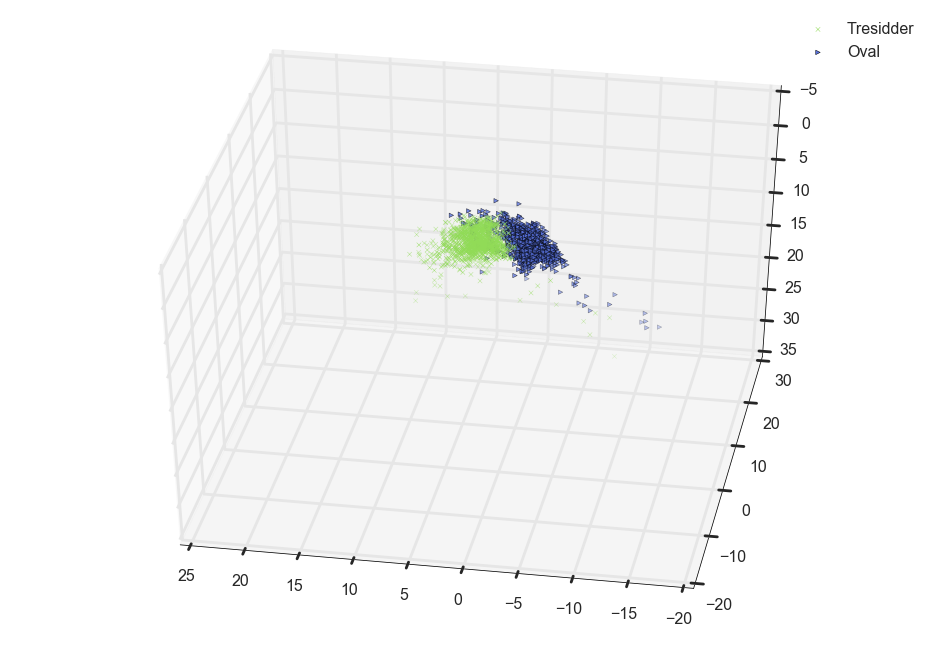

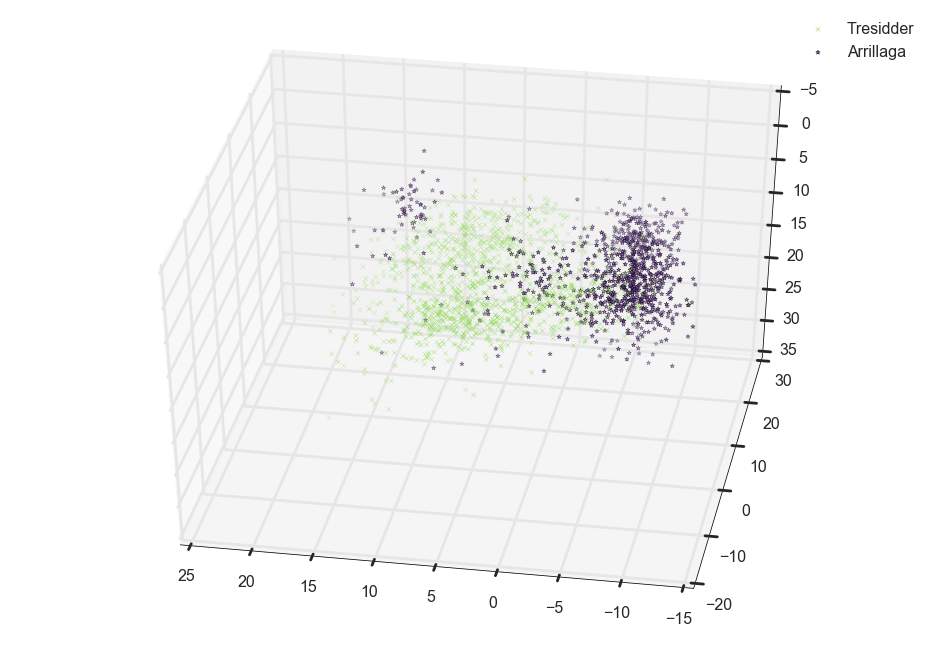

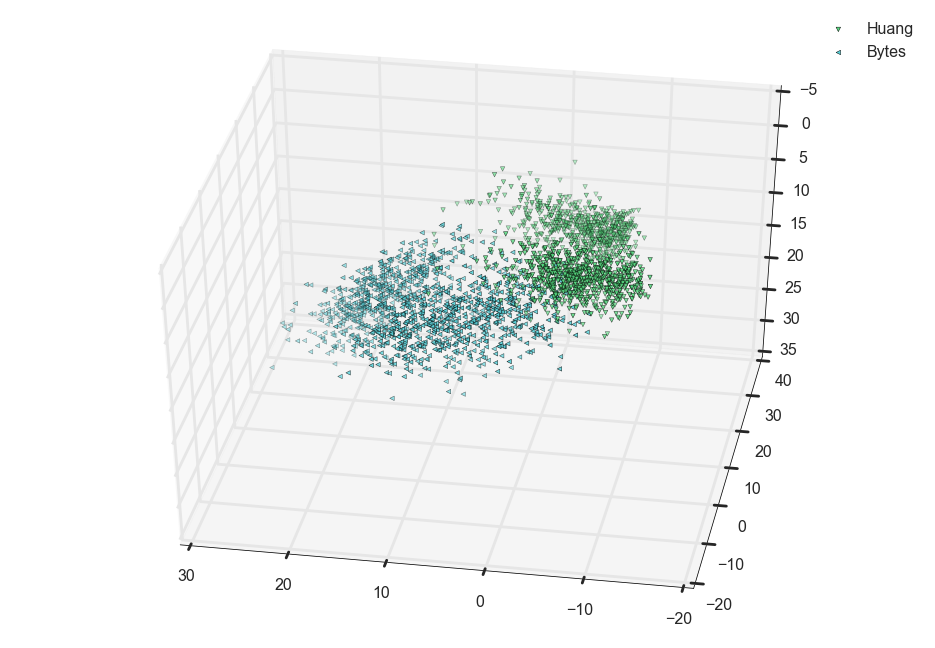

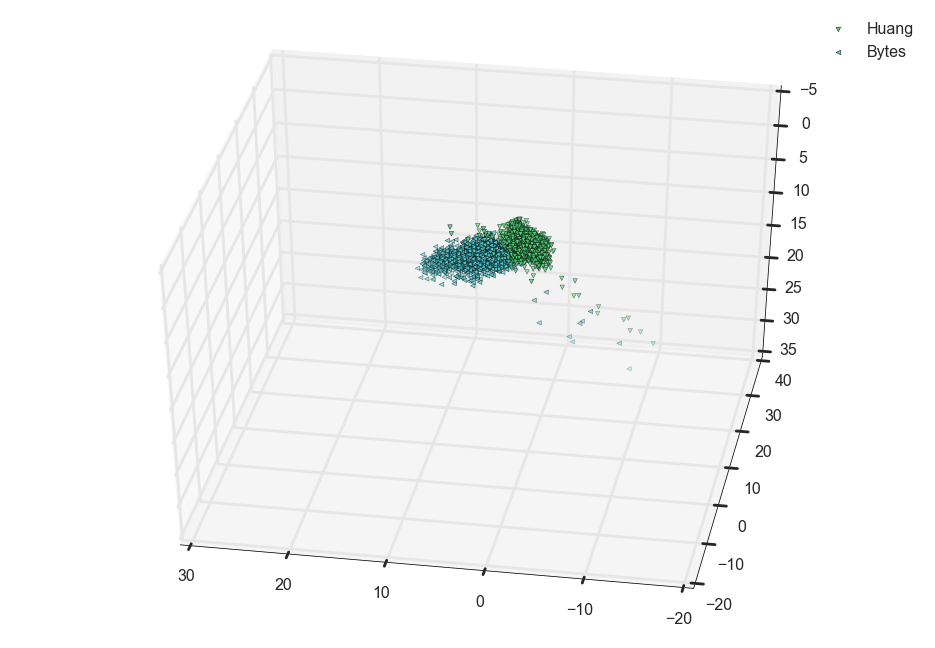

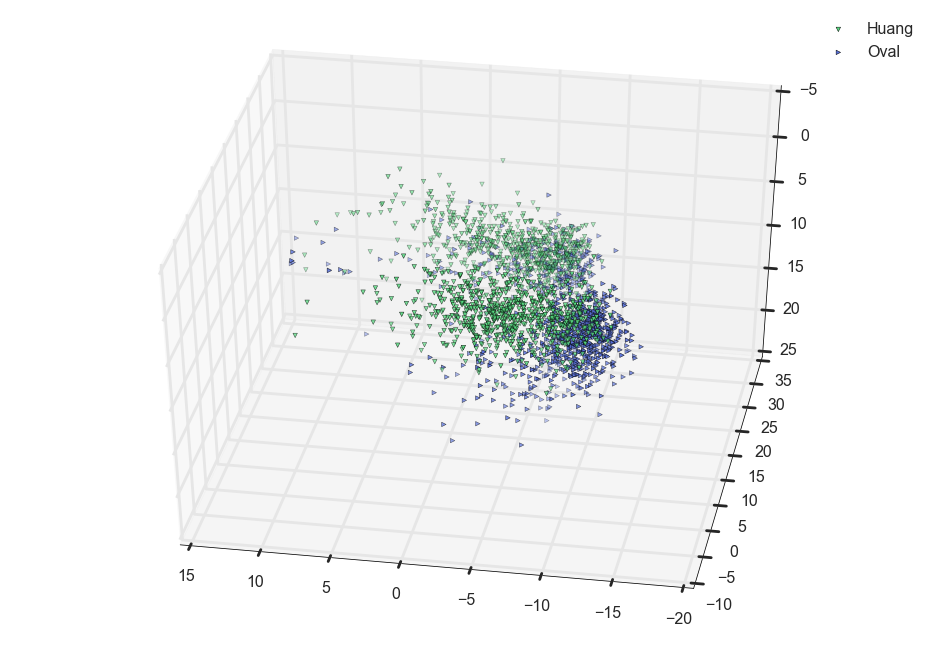

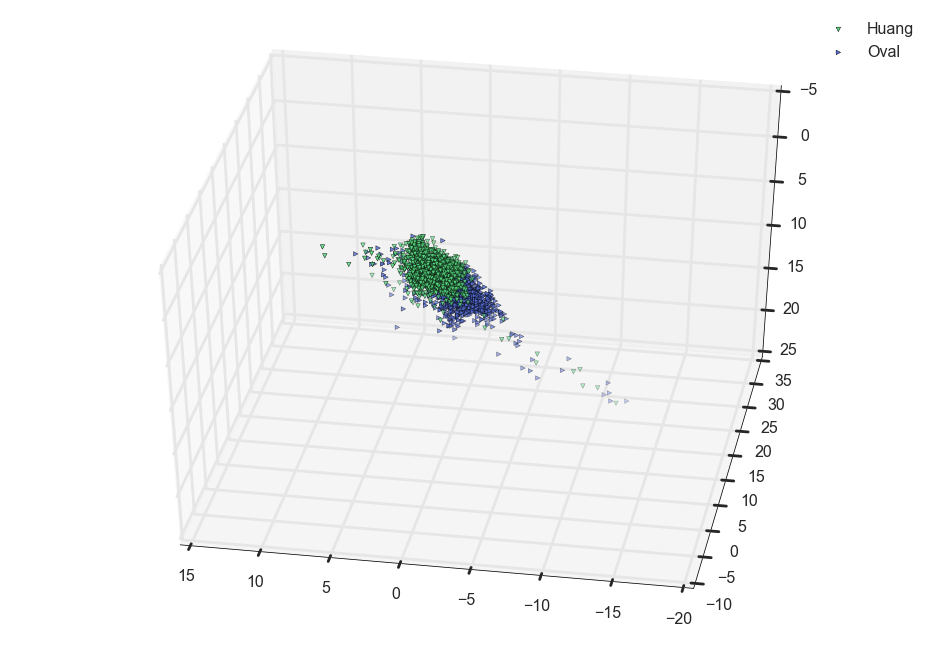

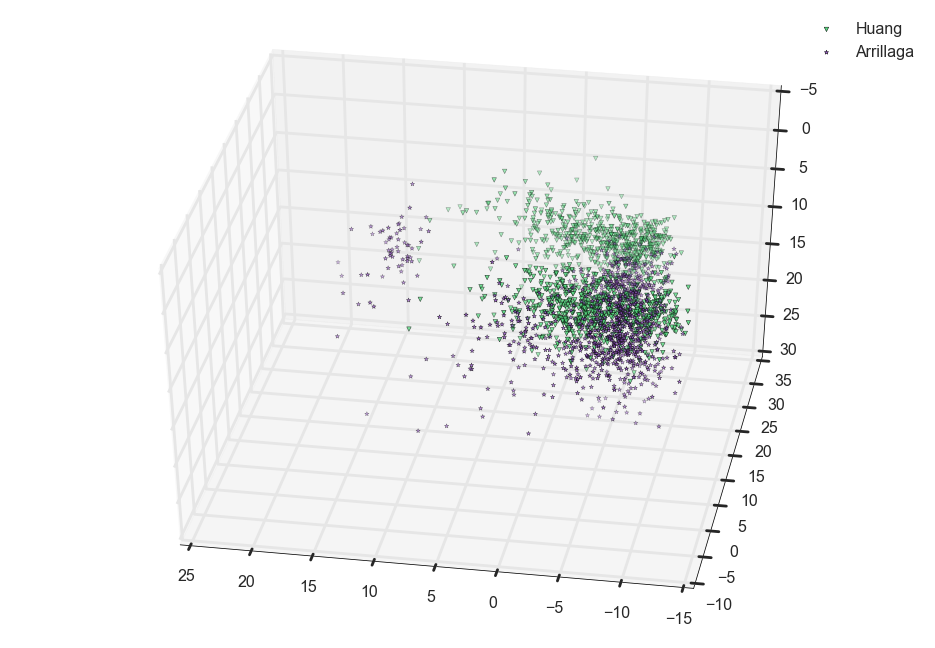

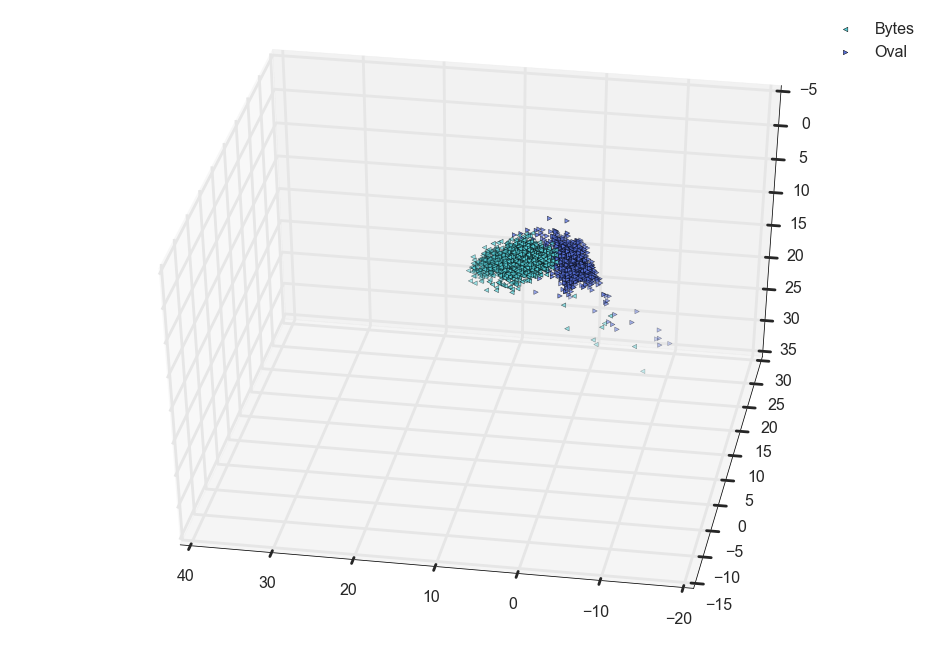

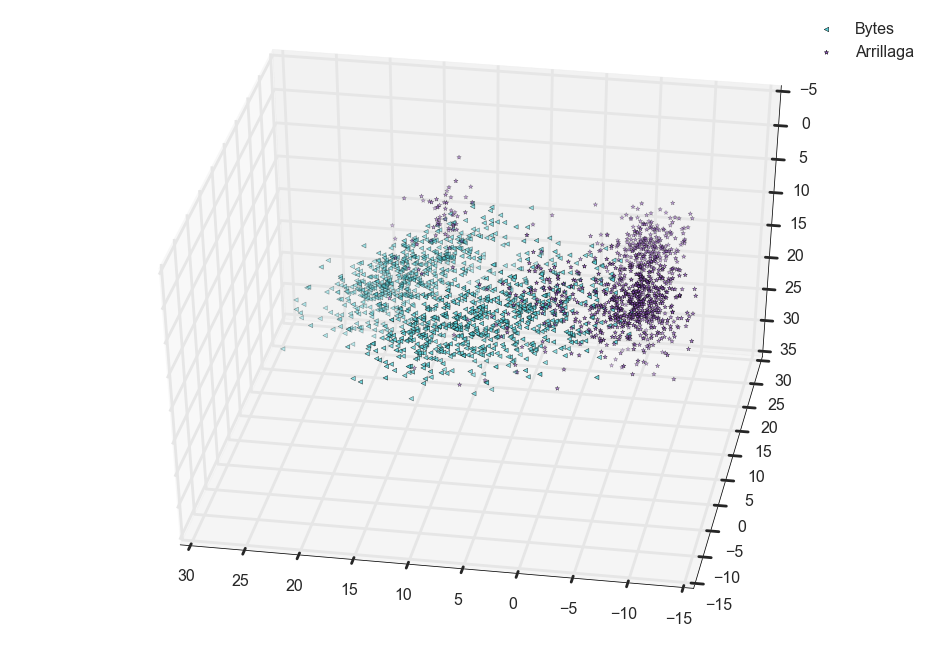

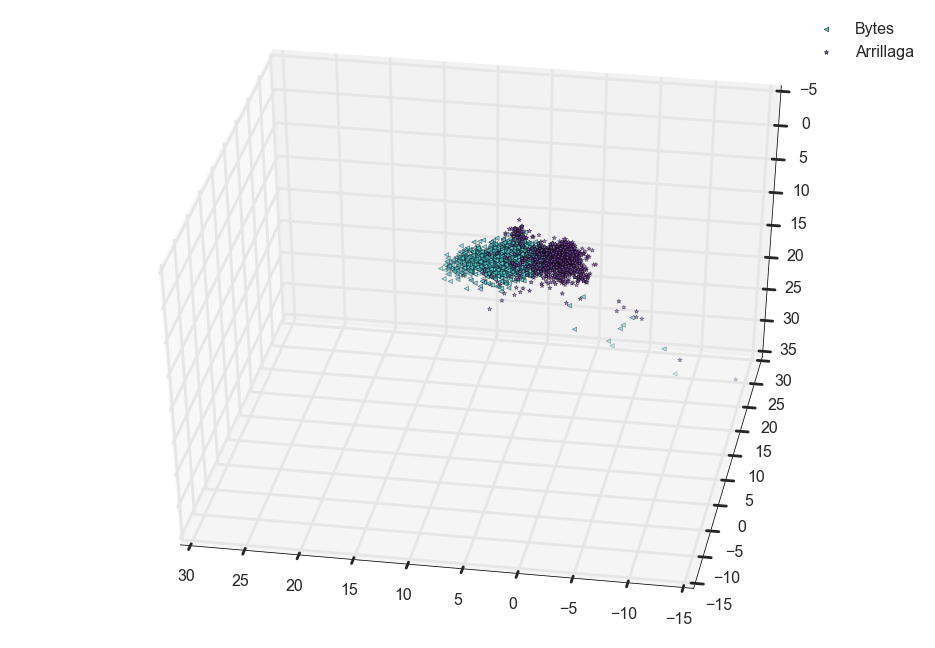

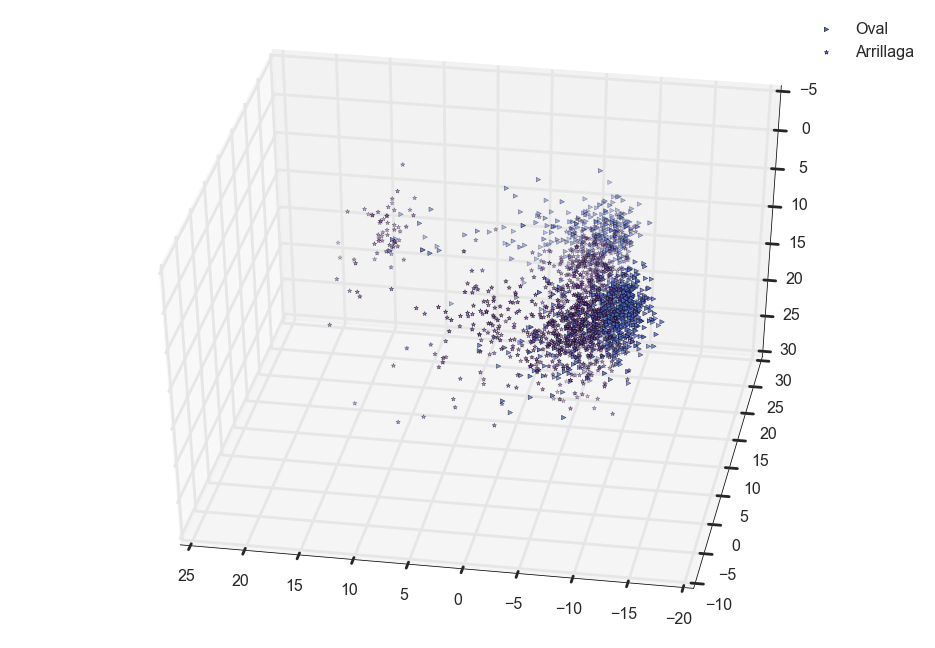

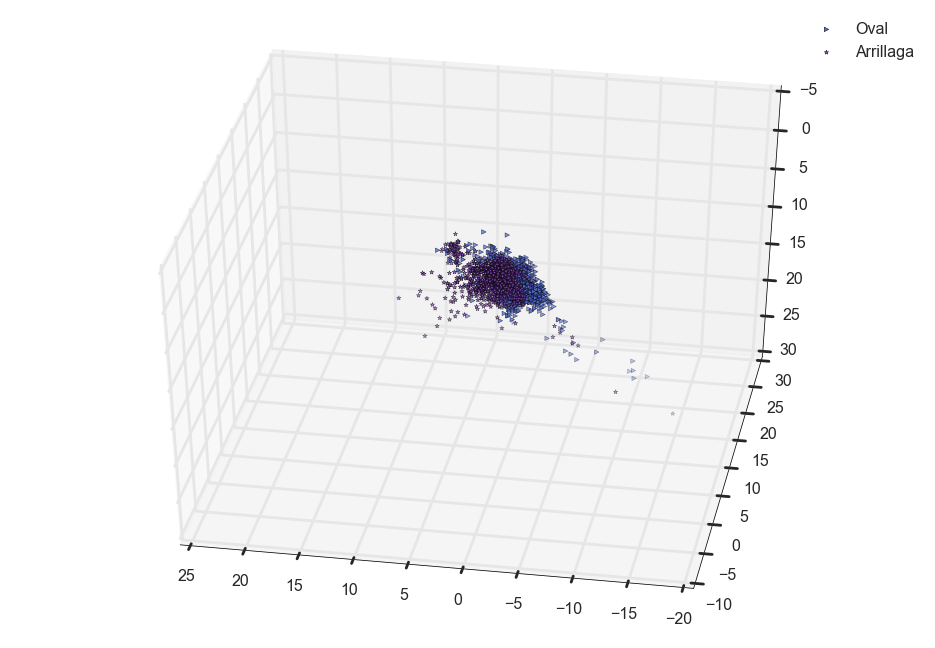

In [92]:
for i in range(7):
    for j in range(i,7):
        if i != j:
            ax = plotRegions(samples.REGIONS,pca_df_test,i,j)
            xlims = ax.get_xlim()
            ylims = ax.get_ylim()
            zlims = ax.get_zlim()
            ax = plotRegions(samples.REGIONS,pca_df,i,j)
            ax.set_xlim(xlims)
            ax.set_ylim(ylims)
            ax.set_zlim(zlims)

In [82]:
train_regions = pca_df.groupby('REGION')
test_regions = pca_df_test.groupby('REGION')

In [83]:
train_regions.describe()

pc1         pc10         pc11         pc12         pc13  \
REGION                                                                          
0      count   840.000000   840.000000   840.000000   840.000000   840.000000   
       mean     -2.097999    -0.228157     0.051620    -0.323809     0.143196   
       std       1.706177     1.060110     0.805083     0.800803     0.961353   
       min     -12.381354    -4.787010    -2.695934    -4.804181    -5.293579   
       25%      -2.974883    -0.695680    -0.448266    -0.822216    -0.196400   
       50%      -2.176259    -0.151035     0.027929    -0.302362     0.300651   
       75%      -1.153605     0.406615     0.508274     0.175901     0.740663   
       max       4.794106     4.088953     4.636739     3.068140     2.979559   
1      count  1200.000000  1200.000000  1200.000000  1200.000000  1200.000000   
       mean     -0.576812    -0.335304     0.032067     0.084521     0.213435   
       std       2.055239     1.221499     1.194123     1.442332     1.134319   
       min     -11.972823    -3.621610    -4.884512   -16.205851    -5.186857   
       25%      -1.818508    -1.093988    -0.692866    -0.410630    -0.372830   
       50%      -0.859380    -0.414434    -0.018483     0.164242     0.224000   
       75%       0.239566     0.276910     0.689848     0.727124     0.858128   
       max       9.023945     8.479492     7.084255     5.428228     5.483241   
2      count  1200.000000  1200.000000  1200.000000  1200.000000  1200.000000   
       mean      1.982145     0.216707     0.170301    -0.056678     0.022261   
       std       1.758012     1.220459     1.150268     1.124449     1.132629   
       min     -10.751087    -4.693124    -4.149037    -7.627985    -4.474734   
       25%       0.977126    -0.567442    -0.561276    -0.695706    -0.685227   
       50%       1.904982     0.216829     0.153582     0.014716     0.010278   
       75%       3.000832     0.970833     0.860262     0.649285     0.734949   
       max       7.659465     5.629569     5.352991     2.971945     4.199374   
3      count  1320.000000  1320.000000  1320.000000  1320.000000  1320.000000   
       mean     -0.940989     0.067343     0.002175     0.354430    -0.023141   
       std       1.379092     0.838686     0.911776     0.807578     0.797221   
       min     -13.829327    -3.682539    -2.241235    -2.523044    -4.360302   
       25%      -1.681688    -0.468056    -0.542478    -0.136116    -0.458442   
       50%      -0.866097     0.046834    -0.075826     0.343898    -0.004193   
       75%      -0.145351     0.542065     0.388996     0.783542     0.456612   
       max       6.247036     3.985951    10.663687     6.951984     3.835110   
4      count  1200.000000  1200.000000  1200.000000  1200.000000  1200.000000   
       mean      3.916733     0.151951    -0.037112     0.150750    -0.270886   
       std       2.510119     1.639774     1.487286     1.009412     1.562814   
       min     -11.495349    -4.506418    -5.826729    -3.518727    -5.037752   
       25%       2.222863    -0.943377    -0.963678    -0.481264    -1.269600   
       50%       3.757539     0.021163    -0.083823     0.130597    -0.270363   
       75%       5.640799     1.112806     0.806019     0.801489     0.734222   
       max       9.957233     7.085124     5.692431     3.091749     4.808646   
5      count  1020.000000  1020.000000  1020.000000  1020.000000  1020.000000   
       mean     -2.743301     0.160478     0.172403    -0.180740     0.245007   
       std       1.777796     1.064606     1.315865     1.154546     0.944033   
       min     -14.478698    -3.063975    -4.568440    -4.280018    -3.059481   
       25%      -3.733279    -0.486217    -0.633089    -0.846574    -0.287096   
       50%      -2.763231     0.133533    -0.019292    -0.274411     0.237310   
       75%      -1.887674     0.796160     0.816259     0.400125     0.834169   
       max       4.346396     4.393731     5.195540  

In [104]:
pca.set_params(n_components=num_pcs/2)

PCA(copy=True, n_components=25, whiten=False)

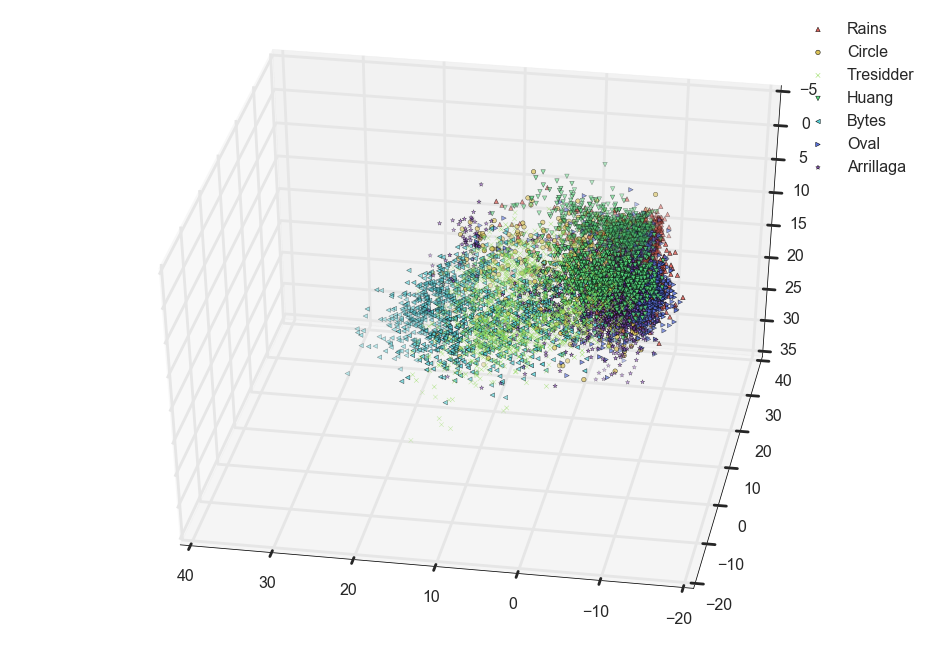

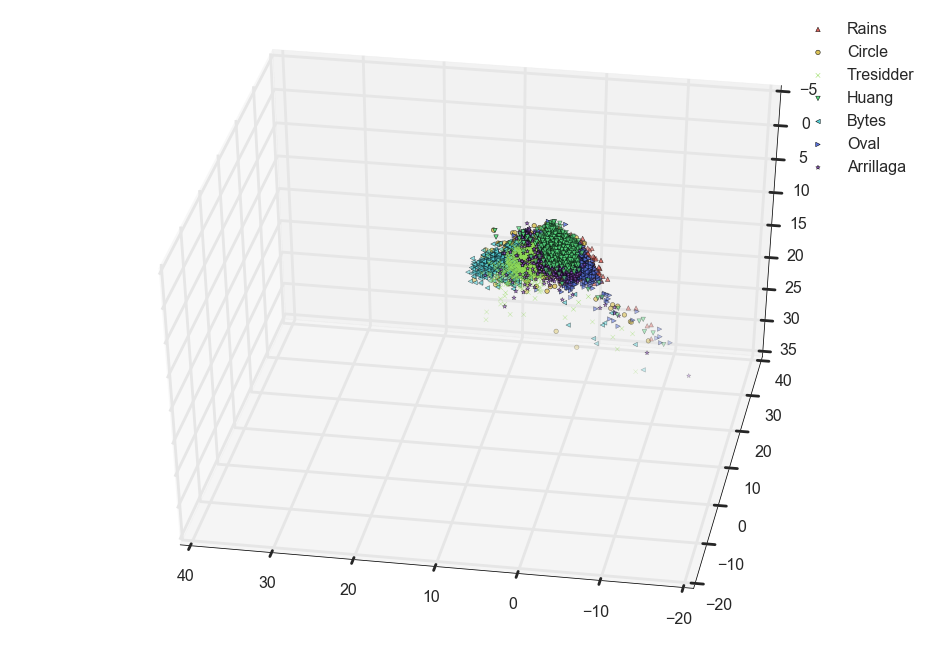

In [107]:
pca_df_test = pd.DataFrame()
test_pca = pca.transform(X_test)
for i in range(pca.n_components):
    pca_df_test["pc%i" % (i+1)] = test_pca[:,i]
pca_df_test['REGION'] = Y_test
ax = plotRegions(samples.REGIONS,pca_df_test,ax=None)
xlims = ax.get_xlim()
ylims = ax.get_ylim()
zlims = ax.get_zlim()

pca_df_train = pd.DataFrame()
for i in range(pca.n_components):
    pca_df_train["pc%i" % (i+1)] = X_pca[:,i]    
pca_df_train['REGION'] = Y_train
ax = plotRegions(samples.REGIONS,pca_df,ax=None)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_zlim(zlims)
plt.show()

In [108]:
pca.n_components

25